# Data analysis and processing

We're going to re-analyse the data from the paper [Compact, low-threshold squeezed light source](https://opg.optica.org/abstract.cfm?uri=oe-27-26-37877), as well as data taken during the project that led to the paper [Distributed quantum sensing in a continuous-variable entangled network](https://www.nature.com/articles/s41567-019-0743-x).

Both of these papers are about [squeezed light](https://omni.wikiwand.com/en/articles/Squeezed_states_of_light) generated by an [optical parametric oscillator (OPO)](https://omni.wikiwand.com/en/articles/Optical_parametric_oscillator). In the textbook description of squeezed vacuum, the variance of the squeezed quadrature (let's say it's $\hat x$) is $\text{Var}(x) = e^{-2r}$ and for the anti-squeezed quadrature ($\hat p$) it is $\text{Var}(p) = e^{2r}$. Here, $r$ is the _squeezing parameter_. For a realistic state, the situation is more complex - $r$ is not well-defined in the experiment, but the variance will instead depend on losses, the frequency that it is observed at, etc.

Denoting by $V_+$ the variance of the anti-squeezing relative to shotnoise (the standard noise level, whose value depends on the definition of the quadrature operators), and by $V_-$ the squeezing variance, the simplest formula for the squeezing of an OPO is for the case of no losses and at DC (i.e. frequency = zero):

$V_\pm = 1 \pm \frac{4x}{(1\mp x)^2},$

where $x=\sqrt{P/P_{th}}$ is the _pump parameter_ given by the power $P$ of the field used for pumping the nonlinear interaction inside the OPO relative to a _threshold power_ $P_{th}$.

For non-zero losses, we have the _overall efficiency_ $\eta = 1-\text{losses}$, and we also introduce the _OPO half-width-half-max bandwidth_ $f_{HWHM}$ and the frequency of observation $f$. Then the expression above becomes

$V_\pm = 1 \pm \frac{4x\eta}{(1\mp x)^2 + (f/f_{HWHM})^2}.$

The variance of a general quadrature $x_\theta$ at an angle $\theta$ with the squeezed quadrature can be obtained by

$V(\theta) = V_-\cos^2\theta + V_+\sin^2\theta$.

Finally, if there is some fluctuation in the observed phase, this can be incorporated by modeling it as a normal distribution around the phase set point with standard deviation $\sigma$, resulting in a variance

$V(\theta) = \frac{1}{2} V_- (1+\cos(2\theta)e^{-2\sigma^2}) + \frac{1}{2} V_+ (1-\cos(2\theta)e^{-2\sigma^2}) .$

#### Data loading and processing

The data for the first paper (the "Jens" paper) has been acquired by a Keysight N9000A signal analyzer. It is in CSV format which is easy to import e.g. with NumPy's `genfromtxt` function.

The data for the second paper (the "Xueshi" paper) has been acquired by a LeCroy HDO6034 oscilloscope. This is in a proprietary binary format, so here we need some custom code to import it. This is available in the `lecroy.py` file.

A better way to store large amounts of data is in the commonly used [HDF5 binary data format](https://omni.wikiwand.com/en/articles/Hierarchical_Data_Format). In Python, this can be used via the [h5py](https://www.h5py.org) package.

We will also look at processing the data. For calculating spectra, filtering time series, etc., we will use tools from `scipy.signal` and `scipy.fft`. For fitting data to theoretical models, we will use tools from `scipy.optimize`.

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import lecroy
import h5py
import os
import sys
from scipy.signal import periodogram, welch
from scipy.fft import rfft, irfft, rfftfreq
from scipy.optimize import curve_fit, least_squares

In [3]:
jens_folder = 'test_data/jens'
jens_files = os.listdir(jens_folder)
xueshi_folder = 'test_data/xueshi'
xueshi_files = os.listdir(xueshi_folder)

In [13]:
def lin2db(lin):
    return 10 * np.log10(lin)

def db2lin(db):
    return 10**(db/10)

In [14]:
Vsq = lambda x, eta, frel: 1 - 4*eta*x / ((1+x)**2 + frel**2)
Vasq = lambda x, eta, frel: 1 + 4*eta*x / ((1-x)**2 + frel**2)
Vrot = lambda x, eta, frel, theta: np.cos(theta*np.pi/180)**2 * Vsq(x, eta, frel) + np.sin(theta*np.pi/180)**2 * Vasq(x, eta, frel)

def Vrotfluct(x, eta, frel, theta, sigma_x=0, sigma_p=None):
    if sigma_p is None:
        sigma_p = sigma_x
        
    Vx = .5 * Vsq(x, eta, frel) * (1 + np.cos(2 * theta * np.pi/180) * np.exp(-2 * (sigma_x * np.pi/180)**2))
    Vp = .5 * Vasq(x, eta, frel) * (1 - np.cos(2 * theta * np.pi/180) * np.exp(-2 * (sigma_p * np.pi/180)**2))

    return Vx + Vp

## Jens data

In [15]:
jens_files

['5MHz_1.1_A.csv',
 '5MHz_4.3_A.csv',
 '5MHz_4.7_S.csv',
 '.ipynb_checkpoints',
 '5MHz_0.5_S.csv',
 '5MHz_3.4_S.csv',
 '5MHz_4.7_A.csv',
 '5MHz_0.5_A.csv',
 '5MHz_2.9_S.csv',
 'SPEC_2.5_A.csv',
 '5MHz_2.4_A.csv',
 'SPEC_1.3_S.csv',
 'SPEC_vac.csv',
 '5MHz_1.9_A.csv',
 'SPEC_2.5_S.csv',
 'SPEC_3.4_A.csv',
 'SPEC_3.4_S.csv',
 '5MHz_1.4_S.csv',
 'SPEC_elec.csv',
 'spectra.png',
 'SPEC_1.3_A.csv',
 '.~lock.5MHz_0.5_S.csv#',
 '5MHz_3.6_A.csv',
 '5MHz_2.4_S.csv',
 '5MHz_2.9_A.csv',
 '5MHz_3.4_A.csv',
 '5MHz_vac.csv',
 '5MHz_4.3_S.csv',
 'power_scaling.png',
 '5MHz_1.4_A.csv',
 '5MHz_3.6_S.csv',
 '5MHz_elec.csv',
 '5MHz_1.9_S.csv',
 '5MHz_1.1_S.csv']

We select the files containing the spectrum:

In [16]:
sq_spec_files = [os.path.join(jens_folder, f) for f in sorted(jens_files) if 'SPEC' in f and '_S' in f]
asq_spec_files = [os.path.join(jens_folder, f) for f in sorted(jens_files) if 'SPEC' in f and '_A' in f]
elec_spec_file = os.path.join(jens_folder, 'SPEC_elec.csv')
vac_spec_file = os.path.join(jens_folder, 'SPEC_vac.csv')
sq_spec_files, asq_spec_files

(['test_data/jens/SPEC_1.3_S.csv',
  'test_data/jens/SPEC_2.5_S.csv',
  'test_data/jens/SPEC_3.4_S.csv'],
 ['test_data/jens/SPEC_1.3_A.csv',
  'test_data/jens/SPEC_2.5_A.csv',
  'test_data/jens/SPEC_3.4_A.csv'])

Read data from the files. The first 45 lines of each file containt metadata, so we first look at these, but then skip them when reading the actual data.

In [17]:
with open(elec_spec_file) as f:
    meta = [f.readline().strip().split(',') for i in range(45)]
for text in meta:
    if len(text) > 1:
        print(f'{text[0]:<25} : {text[1]}')
    else:
        print(text)

['Trace']
['Swept SA']
A.18.12                   : N9000A
503                       : 01
Segment                   : 0
Number of Points          : 5000
Sweep Time                : 0.889488733333
Start Frequency           : 1000000
Stop Frequency            : 120000000
Average Count             : 0
Average Type              : LogPower(Video)
RBW                       : 1100000
RBW Filter                : Gaussian
RBW Filter BW             : 3dB
VBW                       : 300
Sweep Type                : Swept
X Axis Scale              : Lin
PreAmp State              : Off
PreAmp Band               : Low
Trigger Source            : Free
Trigger Level             : 1.2
Trigger Slope             : Positive
Trigger Delay             : 0
Phase Noise Optimization  : Fast
Swept If Gain             : Low
FFT If Gain               : Autorange
RF Coupling               : AC
FFT Width                 : 411900
Ext Ref                   : 10000000
Input                     : RF
RF Calibrator        

In [18]:
electronic = np.genfromtxt(elec_spec_file, delimiter=',', skip_header=45)
vacuum = np.genfromtxt(vac_spec_file, delimiter=',', skip_header=45)
squeezing = np.array([np.genfromtxt(f, delimiter=',', skip_header=45) for f in sq_spec_files])
antisqueezing = np.array([np.genfromtxt(f, delimiter=',', skip_header=45) for f in asq_spec_files])

In [19]:
electronic.shape, vacuum.shape, squeezing.shape, antisqueezing.shape

((5000, 2), (5000, 2), (3, 5000, 2), (3, 5000, 2))

In [20]:
f = electronic[:,0] / 1e6  # to MHz
electronic = electronic[:,1]
vacuum = vacuum[:,1]
squeezing = squeezing[:,:,1]
antisqueezing = antisqueezing[:,:,1]

As we saw from the "Y Axis Units" in the meta data, the spectrum is already given on a logarithmic scale. We also see this when plotting:

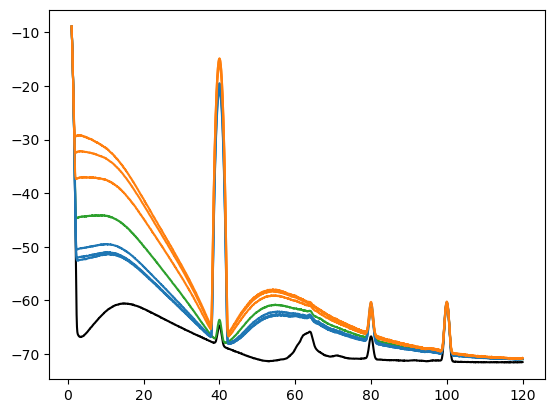

In [21]:
plt.plot(f, electronic, c='k')
plt.plot(f, vacuum, c='C2')
for sq in squeezing:
    plt.plot(f, sq, c='C0')
for asq in antisqueezing:
    plt.plot(f, asq, c='C1')

We are interested in the squeezing and antisqueezing noise variance _relative_ to the vacuum noise, so we normalise to this.
Before doing this, we can subtract the electronic noise which is common for all traces. When performing arithmetics on the spectra, we must first convert from logarithmic to linear scale:

In [22]:
vacuum_corr_lin = db2lin(vacuum) - db2lin(electronic)
squeezing_norm = lin2db((db2lin(squeezing) - db2lin(electronic)) / vacuum_corr_lin)
antisqueezing_norm = lin2db((db2lin(antisqueezing) - db2lin(electronic)) / vacuum_corr_lin)

/tmp/ipykernel_85457/2130157308.py:2: RuntimeWarning: invalid value encountered in log10
  return 10 * np.log10(lin)


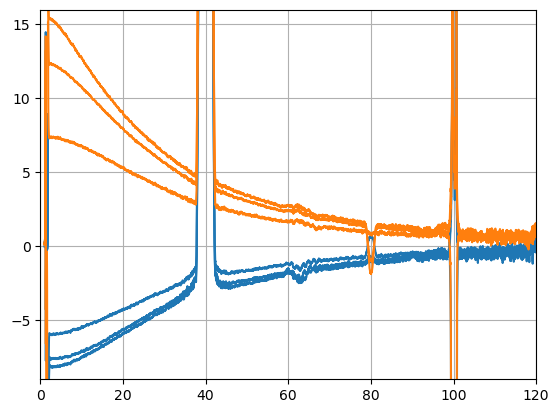

In [81]:
for sq in squeezing_norm:
    plt.plot(f, sq, c='C0')
for asq in antisqueezing_norm:
    plt.plot(f, asq, c='C1')

plt.ylim(-9,16)
plt.xlim(0, 120)
plt.grid()

In [23]:
def res_asq(params, freq, spec):
    x, eta, bw = params
    model = lin2db(Vasq(x, eta, freq/bw))
    residuals = spec - model
    return residuals
    

In [24]:
test_spec = antisqueezing_norm[2]
least_squares(res_asq, [.5,.8,40], args=[f, test_spec])

ValueError: Residuals are not finite in the initial point.

In [25]:
np.sum(res_asq([.5,.8,40], f, test_spec)**2)

nan

In [26]:
mask1 = ~np.isnan(test_spec)
res = least_squares(res_asq, [.5,.8,40], args=[f[mask1], test_spec[mask1]])
res

/tmp/ipykernel_85457/2130157308.py:2: RuntimeWarning: invalid value encountered in log10
  return 10 * np.log10(lin)


     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.378e+01 -1.376e+01 ... -7.074e-01 -5.133e-01]
           x: [ 6.383e-01  1.206e+00  5.006e+01]
        cost: 140515.82806793225
         jac: [[-2.949e+01 -3.455e+00 -5.061e-04]
               [-2.949e+01 -3.455e+00 -5.304e-04]
               ...
               [-2.523e+00 -1.239e+00 -5.833e-02]
               [-2.522e+00 -1.238e+00 -5.831e-02]]
        grad: [-7.298e-01 -4.806e-01 -2.443e-02]
  optimality: 0.7298060274497402
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 16
        njev: 9

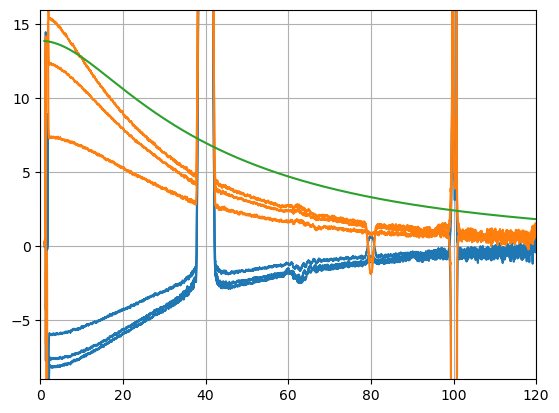

In [27]:
for sq in squeezing_norm:
    plt.plot(f, sq, c='C0')
for asq in antisqueezing_norm:
    plt.plot(f, asq, c='C1')

x_fit, eta_fit, bw_fit = res.x
plt.plot(f, lin2db(Vasq(x_fit, eta_fit, f/bw_fit)), 'C2')

plt.ylim(-9,16)
plt.xlim(0, 120)
plt.grid()

In [28]:
mask2 = ((f>2) & (f<35)) | ((f>45) & (f<75)) | ((f>85) & (f<95))
mask = mask1 & mask2
len(np.nonzero(mask1 & mask2)[0])

3066

In [29]:
res = least_squares(res_asq, [.5,.8,40], args=[f[mask], test_spec[mask]])
res

/tmp/ipykernel_85457/2130157308.py:2: RuntimeWarning: invalid value encountered in log10
  return 10 * np.log10(lin)


     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 3.661e-01  1.155e-01 ... -3.687e-01 -4.025e-01]
           x: [ 7.463e-01  8.170e-01  3.622e+01]
        cost: 34.81870230754104
         jac: [[-3.744e+01 -5.173e+00 -1.079e-02]
               [-3.740e+01 -5.172e+00 -1.103e-02]
               ...
               [-1.596e+00 -1.383e+00 -6.180e-02]
               [-1.596e+00 -1.382e+00 -6.178e-02]]
        grad: [-7.683e-02 -2.945e-02 -1.016e-03]
  optimality: 0.07682780890761687
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 21
        njev: 11

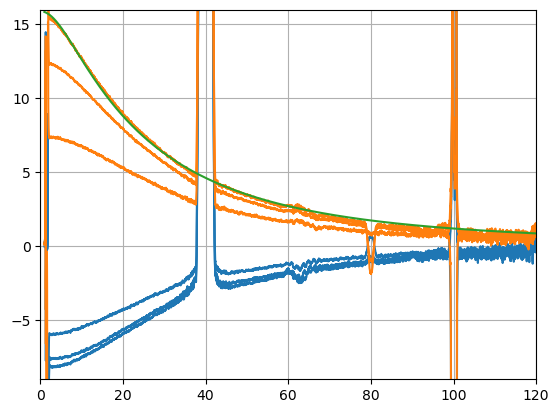

In [30]:
for sq in squeezing_norm:
    plt.plot(f, sq, c='C0')
for asq in antisqueezing_norm:
    plt.plot(f, asq, c='C1')

x_fit, eta_fit, bw_fit = res.x
plt.plot(f, lin2db(Vasq(x_fit, eta_fit, f/bw_fit)), 'C2')

plt.ylim(-9,16)
plt.xlim(0, 120)
plt.grid()

In [31]:
def res_asq2(params, freq, spec):
    x, eta, bw, theta, sigma = params
    model = lin2db(Vrotfluct(x, eta, freq/bw, theta, sigma))
    residuals = spec - model
    return residuals

In [32]:
res = least_squares(res_asq2, [.5,.8,40, 90, 0], args=[f[mask], test_spec[mask]])
res

/tmp/ipykernel_85457/2130157308.py:2: RuntimeWarning: invalid value encountered in log10
  return 10 * np.log10(lin)


     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 5.295e-01  2.785e-01 ... -1.375e-01 -1.713e-01]
           x: [ 9.250e-01  1.649e-01  1.296e+02  1.446e+02  0.000e+00]
        cost: 9.984619789833456
         jac: [[-1.128e+02 -2.560e+01 ...  2.084e-01  0.000e+00]
               [-1.127e+02 -2.560e+01 ...  2.084e-01  0.000e+00]
               ...
               [-1.679e+00 -5.786e+00 ...  7.082e-02  0.000e+00]
               [-1.678e+00 -5.783e+00 ...  7.080e-02  0.000e+00]]
        grad: [-2.761e-02 -2.916e-02 -6.587e-05  2.552e-04  0.000e+00]
  optimality: 0.029157144104111188
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
        nfev: 191
        njev: 148

In [33]:
res = least_squares(res_asq2, [.5,.8,40, 90, 0], bounds=([0,.5,10,80,0], [.99,1,50,100,10]), args=[f[mask], test_spec[mask]])
res

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 3.864e-01  1.358e-01 ... -3.547e-01 -3.885e-01]
           x: [ 7.266e-01  1.000e+00  3.387e+01  1.000e+02  1.000e-10]
        cost: 30.43938179355176
         jac: [[-3.535e+01 -4.225e+00 ...  2.671e-02  0.000e+00]
               [-3.531e+01 -4.225e+00 ...  2.671e-02  0.000e+00]
               ...
               [-1.628e+00 -1.119e+00 ...  1.221e-02  0.000e+00]
               [-1.627e+00 -1.119e+00 ...  1.221e-02  0.000e+00]]
        grad: [ 9.092e-03 -9.185e-01  1.915e-03 -8.477e-01  0.000e+00]
  optimality: 0.04572874629584349
 active_mask: [ 0  1  0  1 -1]
        nfev: 39
        njev: 35

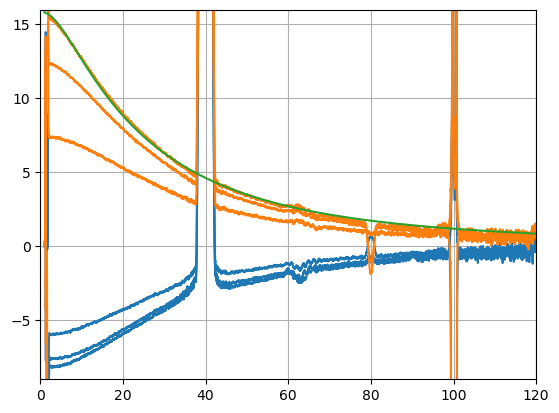

In [34]:
for sq in squeezing_norm:
    plt.plot(f, sq, c='C0')
for asq in antisqueezing_norm:
    plt.plot(f, asq, c='C1')

x_fit, eta_fit, bw_fit, theta_fit, sigma_fit = res.x
plt.plot(f, lin2db(Vrotfluct(x_fit, eta_fit, f/bw_fit, theta_fit, sigma_fit)), 'C2')

plt.ylim(-9,16)
plt.xlim(0, 120)
plt.grid()

In [35]:
asq_spec = antisqueezing_norm[2]
sq_spec = squeezing_norm[2]

def res_asq3(params, freq, sq_spec, asq_spec):
    x, eta, bw, theta_sq, theta_asq, sigma = params
    sq_model = lin2db(Vrotfluct(x, eta, freq/bw, theta_sq, sigma))
    asq_model = lin2db(Vrotfluct(x, eta, freq/bw, theta_asq, sigma))
    model = np.concatenate([sq_model, asq_model])
    spec = np.concatenate([sq_spec, asq_spec])
    residuals = spec - model
    return residuals

In [36]:
res = least_squares(res_asq3, [.5,.8,40, 0, 90, 0], 
                    bounds=([0,.5,10,-10,80,0], [.99,1,50,10,100,10]), 
                    args=[f[mask], sq_spec[mask], sq_spec[mask]])
res

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.712e+01 -1.233e+01 ... -8.665e-01 -8.805e-01]
           x: [ 1.379e-02  1.000e+00  3.327e+01 -7.368e-03  8.000e+01
                1.000e-10]
        cost: 60987.58411912802
         jac: [[ 1.731e+01  2.453e-01 ...  0.000e+00  0.000e+00]
               [ 1.731e+01  2.453e-01 ...  0.000e+00  0.000e+00]
               ...
               [-1.786e+00 -2.455e-02 ... -3.109e-04  0.000e+00]
               [-1.785e+00 -2.454e-02 ... -3.107e-04  0.000e+00]]
        grad: [-1.044e-01 -7.630e+01 -1.891e-02 -1.645e-02  2.108e+01
                0.000e+00]
  optimality: 0.3164217426547201
 active_mask: [ 0  1  0  0 -1 -1]
        nfev: 62
        njev: 59

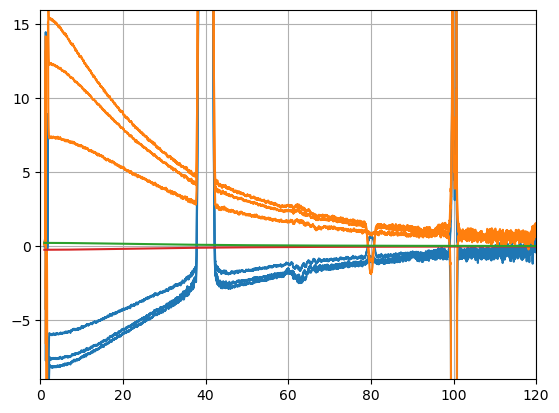

In [37]:
for sq in squeezing_norm:
    plt.plot(f, sq, c='C0')
for asq in antisqueezing_norm:
    plt.plot(f, asq, c='C1')

x_fit, eta_fit, bw_fit, theta_sq_fit, theta_asq_fit, sigma_fit = res.x
plt.plot(f, lin2db(Vrotfluct(x_fit, eta_fit, f/bw_fit, theta_sq_fit, sigma_fit)), 'C3')
plt.plot(f, lin2db(Vrotfluct(x_fit, eta_fit, f/bw_fit, theta_asq_fit, sigma_fit)), 'C2')

plt.ylim(-9,16)
plt.xlim(0, 120)
plt.grid()

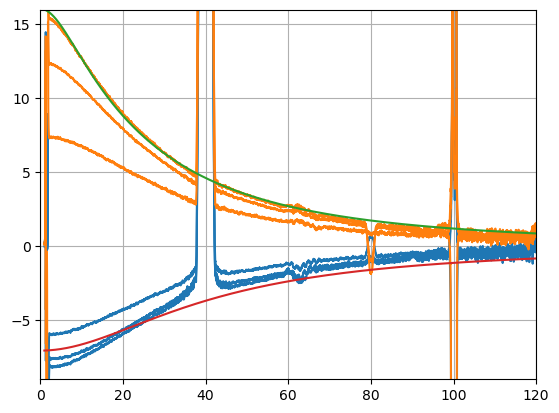

In [28]:
for sq in squeezing_norm:
    plt.plot(f, sq, c='C0')
for asq in antisqueezing_norm:
    plt.plot(f, asq, c='C1')

x_fit, eta_fit, bw_fit, theta_sq_fit, theta_asq_fit, sigma_fit = [.75,.82,36,0,90,0]
plt.plot(f, lin2db(Vrotfluct(x_fit, eta_fit, f/bw_fit, theta_sq_fit, sigma_fit)), 'C3')
plt.plot(f, lin2db(Vrotfluct(x_fit, eta_fit, f/bw_fit, theta_asq_fit, sigma_fit)), 'C2')

plt.ylim(-9,16)
plt.xlim(0, 120)
plt.grid()

### Save to HDF5

In [38]:
meta_elec = np.genfromtxt(elec_spec_file, delimiter=',', skip_header=2, max_rows=42, dtype='S')
meta_elec

array([[b'A.18.12', b'N9000A'],
       [b'503 ', b'01'],
       [b'Segment', b'0'],
       [b'Number of Points', b'5000'],
       [b'Sweep Time', b'0.889488733333'],
       [b'Start Frequency', b'1000000'],
       [b'Stop Frequency', b'120000000'],
       [b'Average Count', b'0'],
       [b'Average Type', b'LogPower(Video)'],
       [b'RBW', b'1100000'],
       [b'RBW Filter', b'Gaussian'],
       [b'RBW Filter BW', b'3dB'],
       [b'VBW', b'300'],
       [b'Sweep Type', b'Swept'],
       [b'X Axis Scale', b'Lin'],
       [b'PreAmp State', b'Off'],
       [b'PreAmp Band', b'Low'],
       [b'Trigger Source', b'Free'],
       [b'Trigger Level', b'1.2'],
       [b'Trigger Slope', b'Positive'],
       [b'Trigger Delay', b'0'],
       [b'Phase Noise Optimization', b'Fast'],
       [b'Swept If Gain', b'Low'],
       [b'FFT If Gain', b'Autorange'],
       [b'RF Coupling', b'AC'],
       [b'FFT Width', b'411900'],
       [b'Ext Ref', b'10000000'],
       [b'Input', b'RF'],
       [b'RF Calibr

In [30]:
meta_elec = {a[0]:a[1] for a in meta_elec}
meta_elec

{'A.18.12': 'N9000A',
 '503 ': '01',
 'Segment': '0',
 'Number of Points': '5000',
 'Sweep Time': '0.889488733333',
 'Start Frequency': '1000000',
 'Stop Frequency': '120000000',
 'Average Count': '0',
 'Average Type': 'LogPower(Video)',
 'RBW': '1100000',
 'RBW Filter': 'Gaussian',
 'RBW Filter BW': '3dB',
 'VBW': '300',
 'Sweep Type': 'Swept',
 'X Axis Scale': 'Lin',
 'PreAmp State': 'Off',
 'PreAmp Band': 'Low',
 'Trigger Source': 'Free',
 'Trigger Level': '1.2',
 'Trigger Slope': 'Positive',
 'Trigger Delay': '0',
 'Phase Noise Optimization': 'Fast',
 'Swept If Gain': 'Low',
 'FFT If Gain': 'Autorange',
 'RF Coupling': 'AC',
 'FFT Width': '411900',
 'Ext Ref': '10000000',
 'Input': 'RF',
 'RF Calibrator': 'Off',
 'Attenuation': '20',
 'Ref Level Offset': '0',
 'External Gain': '0',
 'Trace Type': 'Average',
 'Detector': 'Sample',
 'Trace Math': 'Off',
 'Trace Math Oper1': 'Trace5',
 'Trace Math Oper2': 'Trace6',
 'Trace Math Offset': '0',
 'Normalize': 'Off',
 'Trace Name': 'Trace1

In [39]:
with h5py.File('squeezing_data.hdf5', 'w') as file:
    dset_spec = file.create_group('spectrum')
    dset_freq = dset_spec.create_dataset('frequencies', data=f)
    dset_elec = dset_spec.create_dataset('electronic', data=electronic)
    dset_vac = dset_spec.create_dataset('vacuum', data=vacuum)
    dset_sqz = dset_spec.create_dataset('squeezing', data=squeezing)
    dset_asqz = dset_spec.create_dataset('antisqueezing', data=antisqueezing)
    for key, val in meta_elec:
        dset_spec.attrs[key] = val

In [41]:
with h5py.File('squeezing_data_zipped.hdf5', 'w') as file:
    dset_spec = file.create_group('spectrum')
    dset_freq = dset_spec.create_dataset('frequencies', data=f, chunks=True, compression='gzip')
    dset_elec = dset_spec.create_dataset('electronic', data=electronic, chunks=True, compression='gzip')
    dset_vac = dset_spec.create_dataset('vacuum', data=vacuum, chunks=True, compression='gzip')
    dset_sqz = dset_spec.create_dataset('squeezing', data=squeezing, chunks=True, compression='gzip')
    dset_asqz = dset_spec.create_dataset('antisqueezing', data=antisqueezing, chunks=True, compression='gzip')
    dset_spec.attrs['meta'] = meta_elec

In [45]:
file = h5py.File('squeezing_data_zipped.hdf5', 'r')
list(file.keys())

['spectrum']

In [46]:
list(file['spectrum'].keys())

['antisqueezing', 'electronic', 'frequencies', 'squeezing', 'vacuum']

In [48]:
spec = file['spectrum']
spec['frequencies'][:]

array([  1.        ,   1.02380476,   1.04760952, ..., 119.95239048,
       119.97619524, 120.        ])

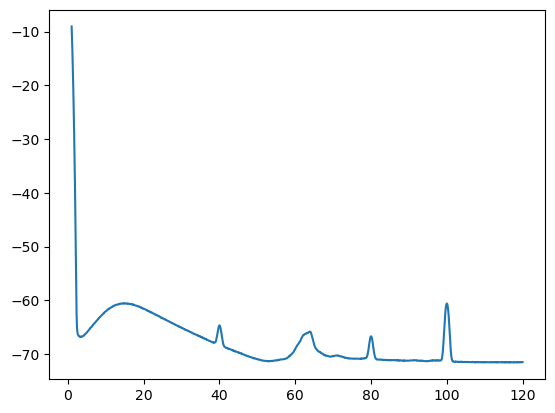

In [49]:
spec = file['spectrum']
plt.plot(spec['frequencies'][:], spec['electronic'][:])
file.close()

## Xueshi data

In [50]:
datasets = ['electronic', 'shotnoise', 'squeezing', 'antisqueezing']
channels = ['C1', 'C2', 'C3', 'C4']

def get_file_list(dataset, channel):
    folder = os.path.join(xueshi_folder, dataset, channel)
    fns = sorted(os.listdir(folder))
    fns = [os.path.join(folder, fn) for fn in fns]
    return fns

files = {ds:
           {ch:get_file_list(ds, ch) for ch in channels}
           for ds in datasets}

In [51]:
meta, times, data = lecroy.read(files['shotnoise']['C1'][0], scale=False)
dt = meta['horiz_interval']
fs = 1/dt
N = len(data[0])
t = np.linspace(0, fs*N, N, endpoint=False)
f = rfftfreq(N, dt)
# meta

In [52]:
meta

{'descriptor_name': b'WAVEDESC',
 'template_name': b'LECROY_2_3',
 'comm_type': 1,
 'comm_order': 1,
 'wave_descriptor': 346,
 'user_text': 0,
 'res_desc1': 0,
 'trig_time_array': 0,
 'ris_time_array': 0,
 'res_array1': 0,
 'wave_array1': 200004,
 'wave_array2': 0,
 'res_array2': 0,
 'res_array3': 0,
 'instrument_name': b'LECROYHDO6034',
 'instrument_number': 6034,
 'trace_label': b'',
 'reserved1': -31070,
 'reserved2': 1,
 'wave_array_count': 100002,
 'points_per_screen': 100000,
 'first_valid_point': 0,
 'last_valid_point': 100001,
 'first_point': 0,
 'sparsing_factor': 1,
 'segment_index': 0,
 'subarray_count': 1,
 'sweeps_per_acq': 1,
 'points_per_pair': 0,
 'pair_offset': 0,
 'vertical_gain': 1.249999968422344e-05,
 'vertical_offset': -0.0,
 'max_value': 31744.0,
 'min_value': -32000.0,
 'nominal_bits': 12,
 'nom_subarray_count': 1,
 'horiz_interval': 1.999999943436137e-09,
 'horiz_offset': -0.00010000060683430235,
 'pixel_offset': -9.999999999999999e-05,
 'vert_unit': b'V',
 'ho

In [53]:
for ds in datasets:
    data = np.array([[
        lecroy.read(f, scale=False)[2] for f in files[ds][ch]]
                     for ch in channels])
    data = data.squeeze()
    globals()[ds] = data


In [89]:
electronic.shape, shotnoise.shape, squeezing.shape, antisqueezing.shape

((4, 200, 100002), (4, 200, 100002), (4, 200, 100002), (4, 200, 100002))

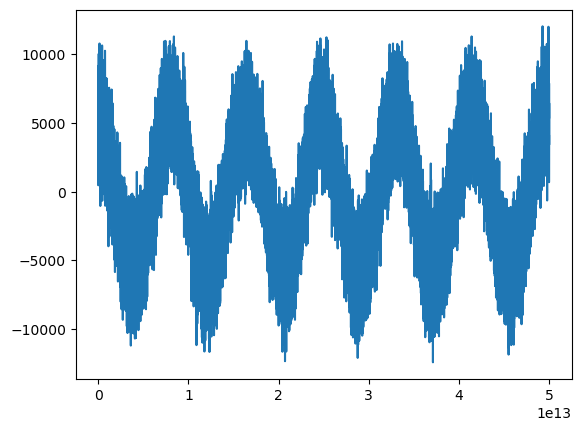

In [54]:
plt.plot(t, antisqueezing[0,0])

## Exercises

Find the Jens data here: https://www.dropbox.com/scl/fo/3hct1gtuo9la8ysoyhuk2/AAuzFp9D7BVOpwDPJKEN_F0?rlkey=0dkbj53brwayjnj72jnzemau6&dl=0

And Xueshi data here: https://www.dropbox.com/scl/fo/as7ek7z1nezg2urofje4h/AD8NKSYoHrOBiPaVM9FnJMk?rlkey=4qmt8zoeqpv1h13feffsd9ssg&dl=0

1. In Jens' data, load the "5MHz..." files and repackage them into an HDF5 file together with metadata and the power values obtained from the file names.
2. Reproduce the figure `power_scaling.png`: Calculate the noise variance for each of the traces and do a fit to the model for OPO squeezing variance.
3. Load all of Xueshi's data using `lecroy.read` and repackage them into an HDF5 file.
4. On the raw time traces of squeezing and anti-squeezing, try to create and apply a filter that can remove the strong oscillation at around 28 MHz. Look into e.g. `firwin`, `iirwin`, `lfilter` or other methods of `scipy.signal`.
5. Calculate the averaged spectrum of the data. You can consider each of the (electronic, shotnoise, squeezing, antisqueezing) to have been acquired under constant conditions, so it is okay to average all the traces for each channel. Look into `rfft` and `rfftfreq` of `scipy.fft` and/or `periodogram` and `welch` of `scipy.signal`.